<h1 align='center'>  HR ANALYTICS CHALLENGE </h1>
<h3 align='center'> <b>Predict Whether a Potential Promotee Will be Promoted or Not</b> </h3>

### **The Challenge**

HR analytics is revolutionising the way human resources departments operate, leading to higher efficiency and better results overall. Human resources has been using analytics for years. However, the collection, processing and analysis of data has been largely manual, and given the nature of human resources dynamics and HR KPIs, the approach has been constraining HR. Therefore, it is surprising that HR departments woke up to the utility of machine learning so late in the game. 
<br></br>
#### **Problem Statement**

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

1. They first identify a set of employees based on recommendations/ past performance
2. Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
3. At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion

For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.



## 0. Import relevant Dependencies

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________'.

In [2]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Display all the columns/rows of the DataFrame.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Loading the required Data

In [3]:
# Import the train data.
train = pd.read_csv('train.csv')

In [4]:
# Viewing the train dataset
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
print("Dimensionality of the train dataset: ", train.shape)

Dimensionality of the train dataset:  (54808, 14)


### All the Lifrcycle in A Data Science Project

1. **Data Analysis / Data Preprocessing**
2. **Feature Engineering**
3. **Feature Selection**
4. **Model Building**
5. **Model Deployment**


## 2. Exploratory Data Analysis
**PROBLEM:** To predict whether a Potential Promotee Will be Promoted or Not

### Missing Values

- In any dataset we will initially try to find out where the missing data are, because then we will know what are the major NaN values in our dataset. 

<AxesSubplot:>

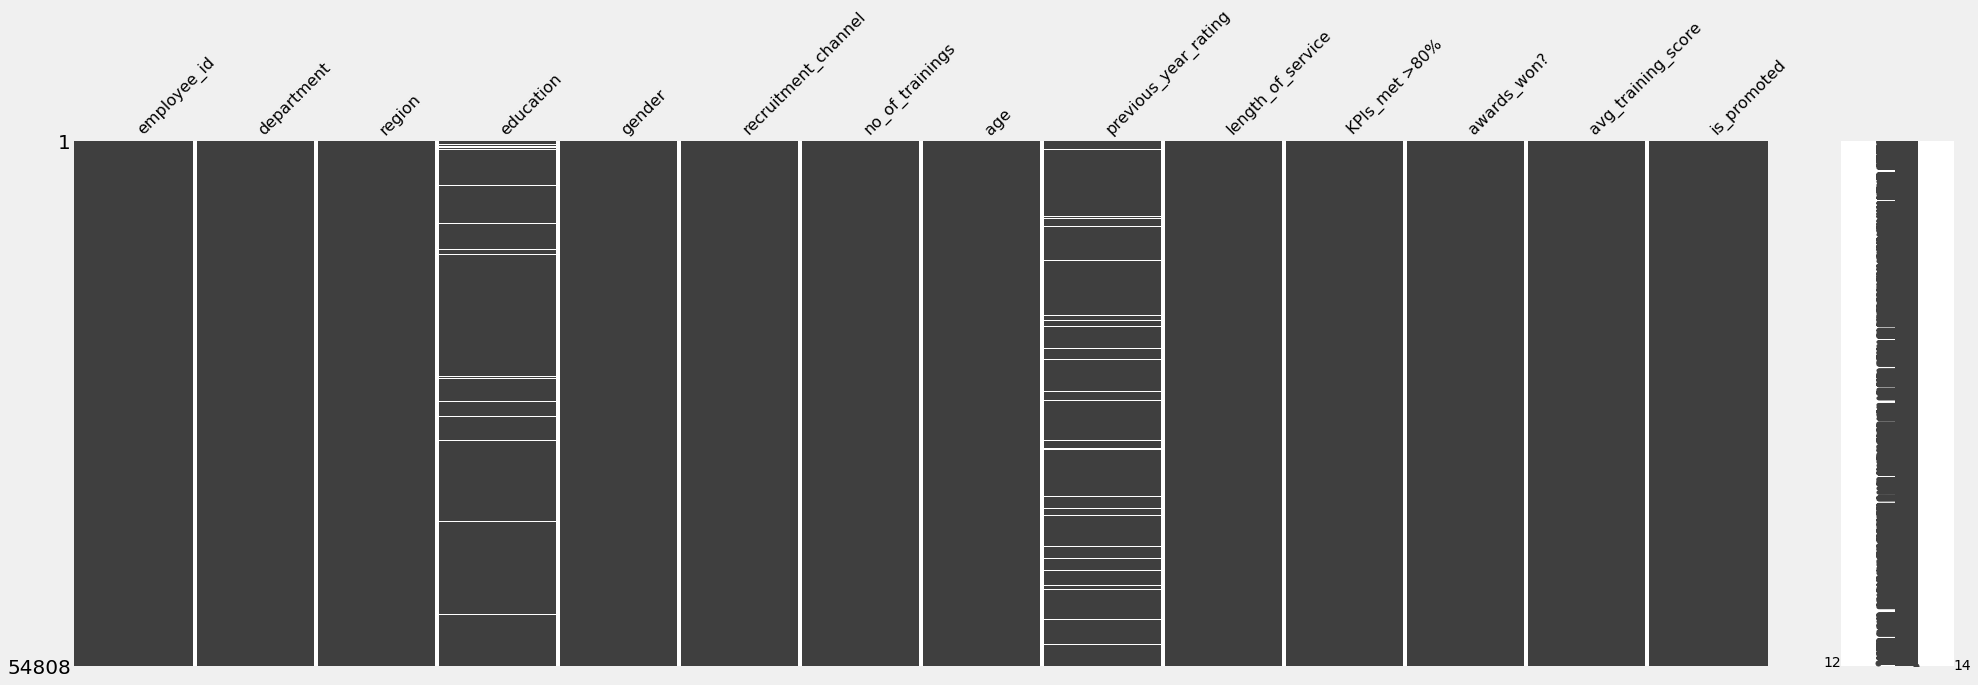

In [6]:
# To plot a graphic of missing values
missingno.matrix(train,figsize=(30,9))

> Here we can see that only two columns have Missing values and in those the "Previous Year Rating" Column is more in number. Let's understand it a bit more.

In [7]:
# Understanding more about the missing value columns

def missing_values_table(df):
    # number of missing values
    mis_val = df.isnull().sum()

    # % of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # make table # axis '0' concat along index, '1' column
    mis_val_table = pd.concat([mis_val,mis_val_percent], axis= 1) 

    # rename columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})

    # sort by column
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!= 0].sort_values(
        '% of Total Values', ascending= False).round(1) #Review
    print("Your selected dataset has " + str(df.shape[1]) + " columns and " + str(len(df)) + " observations.\n"
         "\n There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    
    # return the dataframe with missing info
    return mis_val_table_ren_columns

missing_values_table(train)

Your selected dataset has 14 columns and 54808 observations.

 There are 2 columns that have missing values.


,Missing Values,% of Total Values
previous_year_rating,4124,7.5
education,2409,4.4


- Since we now got an idea of how the Missing Values are spread about in our dataset, we will be handling them in the Feature Engineering section.

### What Datatypes are there in the dataframe?

We usually consider features with a datatype of object as categorical features. And those with float or int could be numerical features.

However, sometimes the features that we consider as numerical might actually turn out to be categorical.

The next few steps will help us figure out how to process our data so our machine learning model can learn from it.
Ideally all the features will be encoded into a numerical value of some kind (maybe 0 or 1 / something else).

In [8]:
# Datatypes in the dataset
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

### Exploring each of these features 
We will go through each of the columns and see which all we can use in our first models. Some of them needs more preprocessing than the others to get ready.

In [9]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


#### FEATURE 1: Employee_ID

In [10]:
# Checking for duplicated values.
train['employee_id'].duplicated().any()

False

In [11]:
train.drop(columns= 'employee_id', inplace= True)
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


#### FEATURE 2: Department

In [12]:
# Checking for any missing values
train['department'].isnull().any()

False

In [13]:
# Checking for Unique values
train['department'].unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='department'>

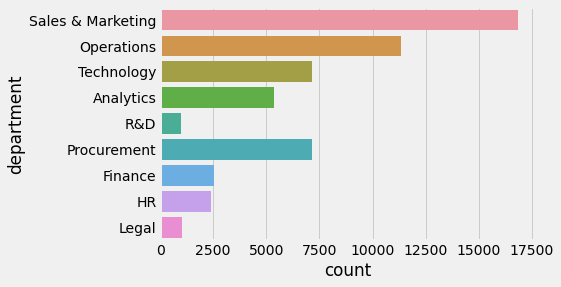

In [14]:
# Understanding how many employees are there in each department.
sns.countplot(y= train['department'])

#### FEATURE 3: Region

In [15]:
# Checking for any missing values
train['region'].isnull().any()

False

In [16]:
# Checking for Unique values
train['region'].unique()

array(['region_7', 'region_22', 'region_19', 'region_23', 'region_26',
       'region_2', 'region_20', 'region_34', 'region_1', 'region_4',
       'region_29', 'region_31', 'region_15', 'region_14', 'region_11',
       'region_5', 'region_28', 'region_17', 'region_13', 'region_16',
       'region_25', 'region_10', 'region_27', 'region_30', 'region_12',
       'region_21', 'region_8', 'region_32', 'region_6', 'region_33',
       'region_24', 'region_3', 'region_9', 'region_18'], dtype=object)

#### FEATURE 4: Education

In [17]:
# Checking for any missing values
train['education'].isnull().any()

True

In [18]:
# Checking for Unique values
train['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

<AxesSubplot:xlabel='count', ylabel='education'>

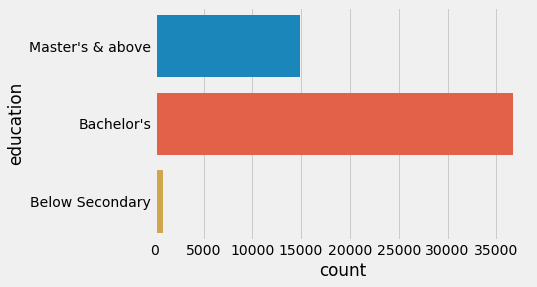

In [19]:
# Understanding the effect of Missing Values.
sns.countplot(y= train['education'])

In [20]:
train[train['education'].isnull()]['department'].unique()

array(['Technology', 'Operations', 'Sales & Marketing', 'R&D',
       'Analytics', 'Procurement', 'HR', 'Finance', 'Legal'], dtype=object)

In [21]:
Min_Edu = train[train['education'].isnull()]['department'].unique()
for i in Min_Edu:
    print((train[train['department'] == i]['education'].mode().iloc[0]), f'for {i}')
    print('Total Count', (train[train['department'] == i]['education'].isnull().sum()), f'for {i}')
    print()

Bachelor's for Technology
Total Count 99 for Technology

Bachelor's for Operations
Total Count 226 for Operations

Bachelor's for Sales & Marketing
Total Count 1575 for Sales & Marketing

Bachelor's for R&D
Total Count 28 for R&D

Bachelor's for Analytics
Total Count 337 for Analytics

Bachelor's for Procurement
Total Count 72 for Procurement

Bachelor's for HR
Total Count 32 for HR

Bachelor's for Finance
Total Count 36 for Finance

Bachelor's for Legal
Total Count 4 for Legal



In [22]:
train['education'].fillna(train['education'].mode().iloc[0], inplace= True)

#### FEATURE 5: Gender

In [23]:
# Checking for any missing values
train['gender'].isnull().any()

False

In [24]:
# Checking for Unique values
train['gender'].unique()

array(['f', 'm'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='gender'>

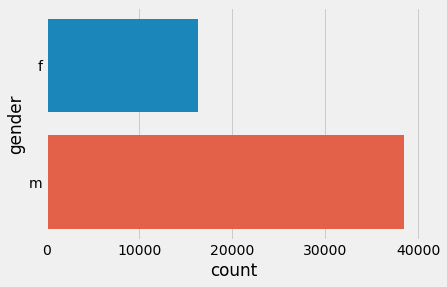

In [25]:
# Understanding the differnet Genders in the workplace.
sns.countplot(y= train['gender'])

#### FEATURE 6: Recruitment Channel

In [26]:
# Checking for any missing values
train['recruitment_channel'].isnull().any()

False

In [27]:
# Checking for Unique values
train['recruitment_channel'].unique()

array(['sourcing', 'other', 'referred'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='recruitment_channel'>

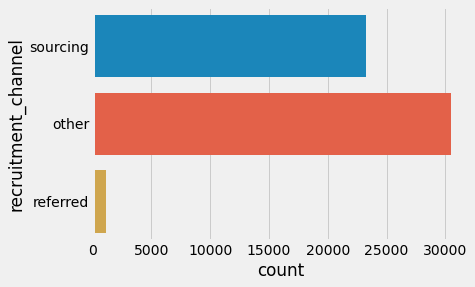

In [28]:
# Understanding how the Recruitment took place in Majority.
sns.countplot(y= train['recruitment_channel'])

#### FEATURE 7: Number of Trainings

In [29]:
# Checking for any missing values
train['no_of_trainings'].isnull().any()

False

In [30]:
# Checking for Unique values
train['no_of_trainings'].unique()

array([ 1,  2,  3,  4,  7,  5,  6,  8, 10,  9], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='no_of_trainings'>

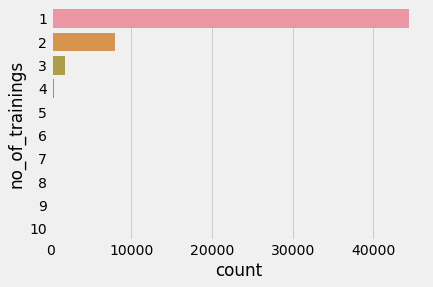

In [31]:
# Understanding the Maximum Number of Trainings taken by the employees.
sns.countplot(y= train['no_of_trainings'])

In [32]:
train['no_of_trainings'].value_counts()

1     44378
2      7987
3      1776
4       468
5       128
6        44
7        12
10        5
9         5
8         5
Name: no_of_trainings, dtype: int64

#### FEATURE 8: Age

In [33]:
# Checking for any missing values
train['age'].isnull().any()

False

<AxesSubplot:xlabel='age', ylabel='Density'>

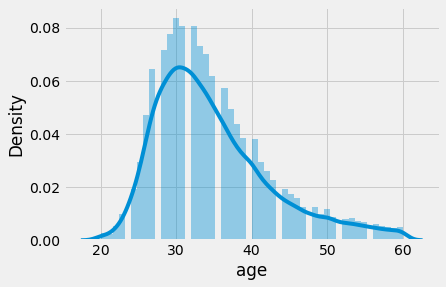

In [34]:
# Understanding the Age distribution.
sns.distplot(train['age'])

In [35]:
train['age'] = pd.cut(train['age'], bins= 5)

<AxesSubplot:xlabel='count', ylabel='age'>

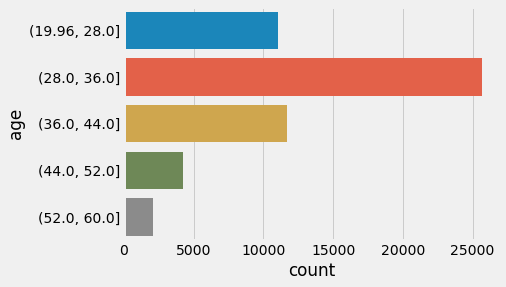

In [36]:
# Understanding the age of the employees.
sns.countplot(y= train['age'])

#### FEATURE 9: Previous Year Rating

In [37]:
# Checking for any missing values
train['previous_year_rating'].isnull().any()

True

In [38]:
# Unique Rating values.
train['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

<AxesSubplot:xlabel='count', ylabel='previous_year_rating'>

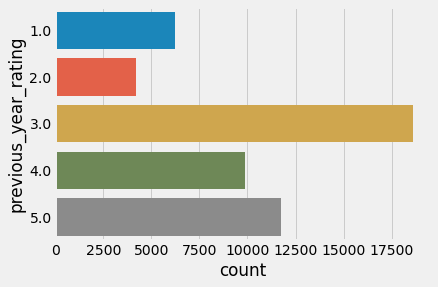

In [39]:
sns.countplot(y= train['previous_year_rating'])

In [40]:
Rating = train[train['previous_year_rating'].isnull()]['department'].unique()
for i in Rating:
    print((train[train['department'] == i]['previous_year_rating'].median()), f'for {i}')

3.0 for Technology
3.0 for Procurement
3.0 for Sales & Marketing
3.0 for Analytics
3.0 for Finance
3.0 for Legal
3.0 for HR
4.0 for Operations
3.0 for R&D


In [41]:
for i in range(0,54808):
    if(train['previous_year_rating'].isnull()[i] == True):
        if(train['department'][i] == 'Technology'):
          train['previous_year_rating'][i] = 3
        elif(train['department'][i] == 'Procurement'):
          train['previous_year_rating'][i] = 3
        elif(train['department'][i] == 'Sales & Marketing'):
          train['previous_year_rating'][i] = 3
        elif(train['department'][i] == 'Analytics'):
          train['previous_year_rating'][i] = 3
        elif(train['department'][i] == 'Finance'):
          train['previous_year_rating'][i] = 3
        elif(train['department'][i] == 'Legal'):
          train['previous_year_rating'][i] = 3
        elif(train['department'][i] == 'HR'):
          train['previous_year_rating'][i] = 3
        elif(train['department'][i] == 'Operations'):
          train['previous_year_rating'][i] = 4
        elif(train['department'][i] == 'R&D'):
          train['previous_year_rating'][i] = 3
        else:
          train['previous_year_rating'][i] = train['previous_year_rating']
    else:
      continue

In [42]:
# Unique Rating values.
train['previous_year_rating'].unique()

array([5., 3., 1., 4., 2.])

<AxesSubplot:xlabel='count', ylabel='previous_year_rating'>

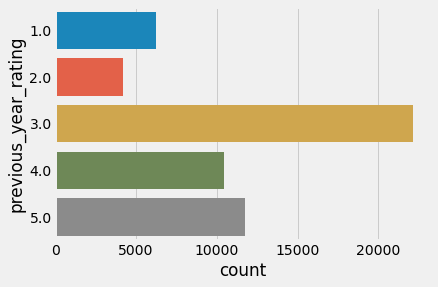

In [43]:
sns.countplot(y= train['previous_year_rating'])

#### FEATURE 10: Length of Service

In [44]:
# Checking for any missing values
train['length_of_service'].isnull().any()

False

In [45]:
# Unique Experience values.
train['length_of_service'].unique()

array([ 8,  4,  7, 10,  2,  5,  6,  1,  3, 16,  9, 11, 26, 12, 17, 14, 13,
       19, 15, 23, 18, 20, 22, 25, 28, 24, 31, 21, 29, 30, 34, 27, 33, 32,
       37], dtype=int64)

<AxesSubplot:xlabel='length_of_service', ylabel='Density'>

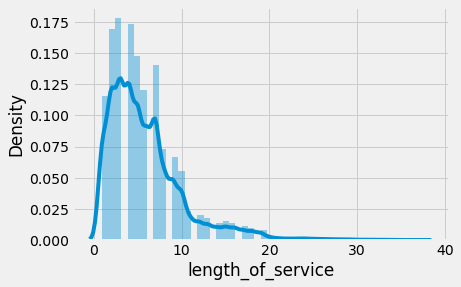

In [46]:
sns.distplot(train['length_of_service'])

#### FEATURE 11: KPI's Met

In [47]:
# Checking for any missing values
train['KPIs_met >80%'].isnull().any()

False

In [48]:
# Unique values.
train['KPIs_met >80%'].unique()

array([1, 0], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='KPIs_met >80%'>

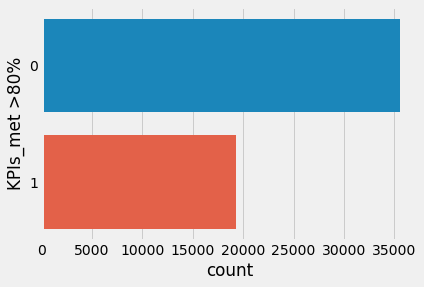

In [49]:
sns.countplot(y= train['KPIs_met >80%'])

#### FEATURE 12: Awards Won

In [50]:
# Checking for any missing values
train['awards_won?'].isnull().any()

False

In [51]:
# Unique values.
train['awards_won?'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='awards_won?'>

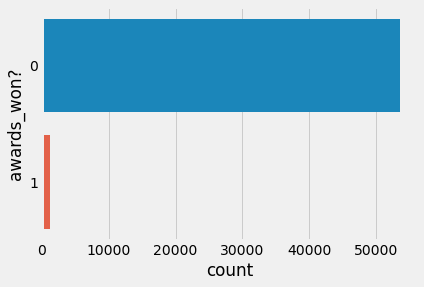

In [52]:
sns.countplot(y= train['awards_won?'])

#### FEATURE 13: Training Score

In [53]:
# Checking for any missing values
train['avg_training_score'].isnull().any()

False

<AxesSubplot:xlabel='avg_training_score', ylabel='Density'>

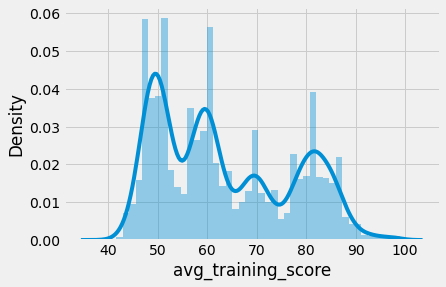

In [54]:
sns.distplot(train['avg_training_score'])

<AxesSubplot:xlabel='avg_training_score'>

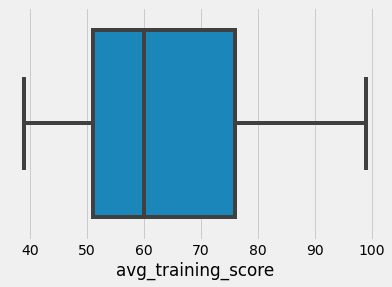

In [55]:
# Outlier Analysis
sns.boxplot(train['avg_training_score'])

#### FEATURE 13: Promotion Status

In [56]:
# Checking for any missing values
train['is_promoted'].isnull().any()

False

In [57]:
# Unique values.
train['is_promoted'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='count', ylabel='is_promoted'>

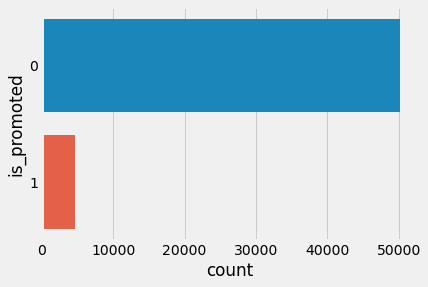

In [58]:
sns.countplot(y= train['is_promoted'])

- Here we can see that there is Class Imbalancment. We will be dealing with this in the future.

### 2.2. Feature Encoding & Feature Scaling

In [59]:
train.drop(columns= 'region', inplace= True)
train['age'] = train['age'].astype(str)
train.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,f,sourcing,1,"(28.0, 36.0]",5.0,8,1,0,49,0
1,Operations,Bachelor's,m,other,1,"(28.0, 36.0]",5.0,4,0,0,60,0
2,Sales & Marketing,Bachelor's,m,sourcing,1,"(28.0, 36.0]",3.0,7,0,0,50,0
3,Sales & Marketing,Bachelor's,m,other,2,"(36.0, 44.0]",1.0,10,0,0,50,0
4,Technology,Bachelor's,m,other,1,"(44.0, 52.0]",3.0,2,0,0,73,0


#### 2.2.1 Dealing with Categorical Columns (Feature Encoding)

In [60]:
# Obtaining the Categorical Columns
categorical_features = [features for features in train.columns if train[features].dtypes == 'O'] 
categorical_features

['department', 'education', 'gender', 'recruitment_channel', 'age']

In [61]:
label_encoder = LabelEncoder()
for feature in categorical_features:
    ## Encode labels in all Categorical Columns.
    train[feature]= label_encoder.fit_transform(train[feature])

train.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,7,2,0,2,1,1,5.0,8,1,0,49,0
1,4,0,1,0,1,1,5.0,4,0,0,60,0
2,7,0,1,2,1,1,3.0,7,0,0,50,0
3,7,0,1,0,2,2,1.0,10,0,0,50,0
4,8,0,1,0,1,3,3.0,2,0,0,73,0


#### 2.2.2 Dealing with Numerical Columns (Feature Scaling)

We are performing Feature Scaling because as we can see there are many Features that are measured to different units. With the help of Feature Scaling we can apply **Machine Learning Algorithms** in a better way.

In [62]:
# Obtaining Numerical Columns
numerical_features = [features for features in train.columns if train[features].dtypes != 'O'] 
numerical_features

['department',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score',
 'is_promoted']

> - Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.

> - Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

<h3>It is important to remember that we need not perform Feature Scaling on our Dependent Variable.</h3>

In [63]:
# Selecting all Features that need to be Scaled except the Target Variable.
scale_feature = [features for features in numerical_features if features not in ['is_promoted']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[scale_feature])

StandardScaler()

In [64]:
# Transform the train set and add the 'is_promoted' Column.
train = pd.concat([train[['is_promoted']].reset_index(drop= True), 
       pd.DataFrame(scaler.transform(train[scale_feature]), columns= scale_feature)], axis= 1) 
       ## Converting to Dataframe as after transform its an array.

train.head()

,is_promoted,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,0,0.808933,1.619758,-1.536223,1.154111,-0.415276,-0.284763,1.385021,0.500460,1.356878,-0.154018,-1.075931
1,0,-0.388183,-0.628838,0.650947,-0.885239,-0.415276,-0.284763,1.385021,-0.437395,-0.736986,-0.154018,-0.253282
2,0,0.808933,-0.628838,0.650947,1.154111,-0.415276,-0.284763,-0.259125,0.265996,-0.736986,-0.154018,-1.001145
3,0,0.808933,-0.628838,0.650947,-0.885239,1.226063,0.718471,-1.903271,0.969387,-0.736986,-0.154018,-1.001145
4,0,1.207972,-0.628838,0.650947,-0.885239,-0.415276,1.721705,-0.259125,-0.906322,-0.736986,-0.154018,0.718939


## 3. Feature Selection

In [65]:
## Capture the Dependent Variable
y = train[['is_promoted']]

## Capture the Independent Variables
X = train.drop(['is_promoted'], axis= 1)

### 3.1 Feature Importance
- We get different Scores for each feature. Higher the Score more relevant the Feature.

In [66]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [67]:
print(model.feature_importances_)

[0.15996111 0.02216194 0.0262816  0.0437656  0.03546365 0.05768739
 0.05955474 0.1628402  0.05442602 0.03760568 0.34025207]


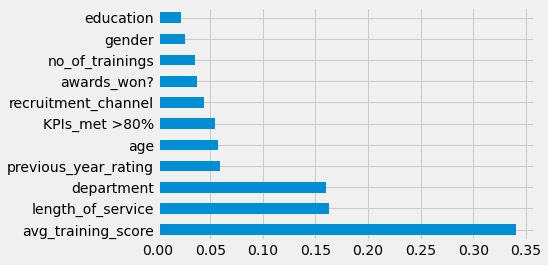

In [68]:
ranked_features = pd.Series(model.feature_importances_, index= X.columns)
ranked_features.nlargest(16).plot(kind= 'barh')
plt.show()

### 3.2 Correlation

<AxesSubplot:>

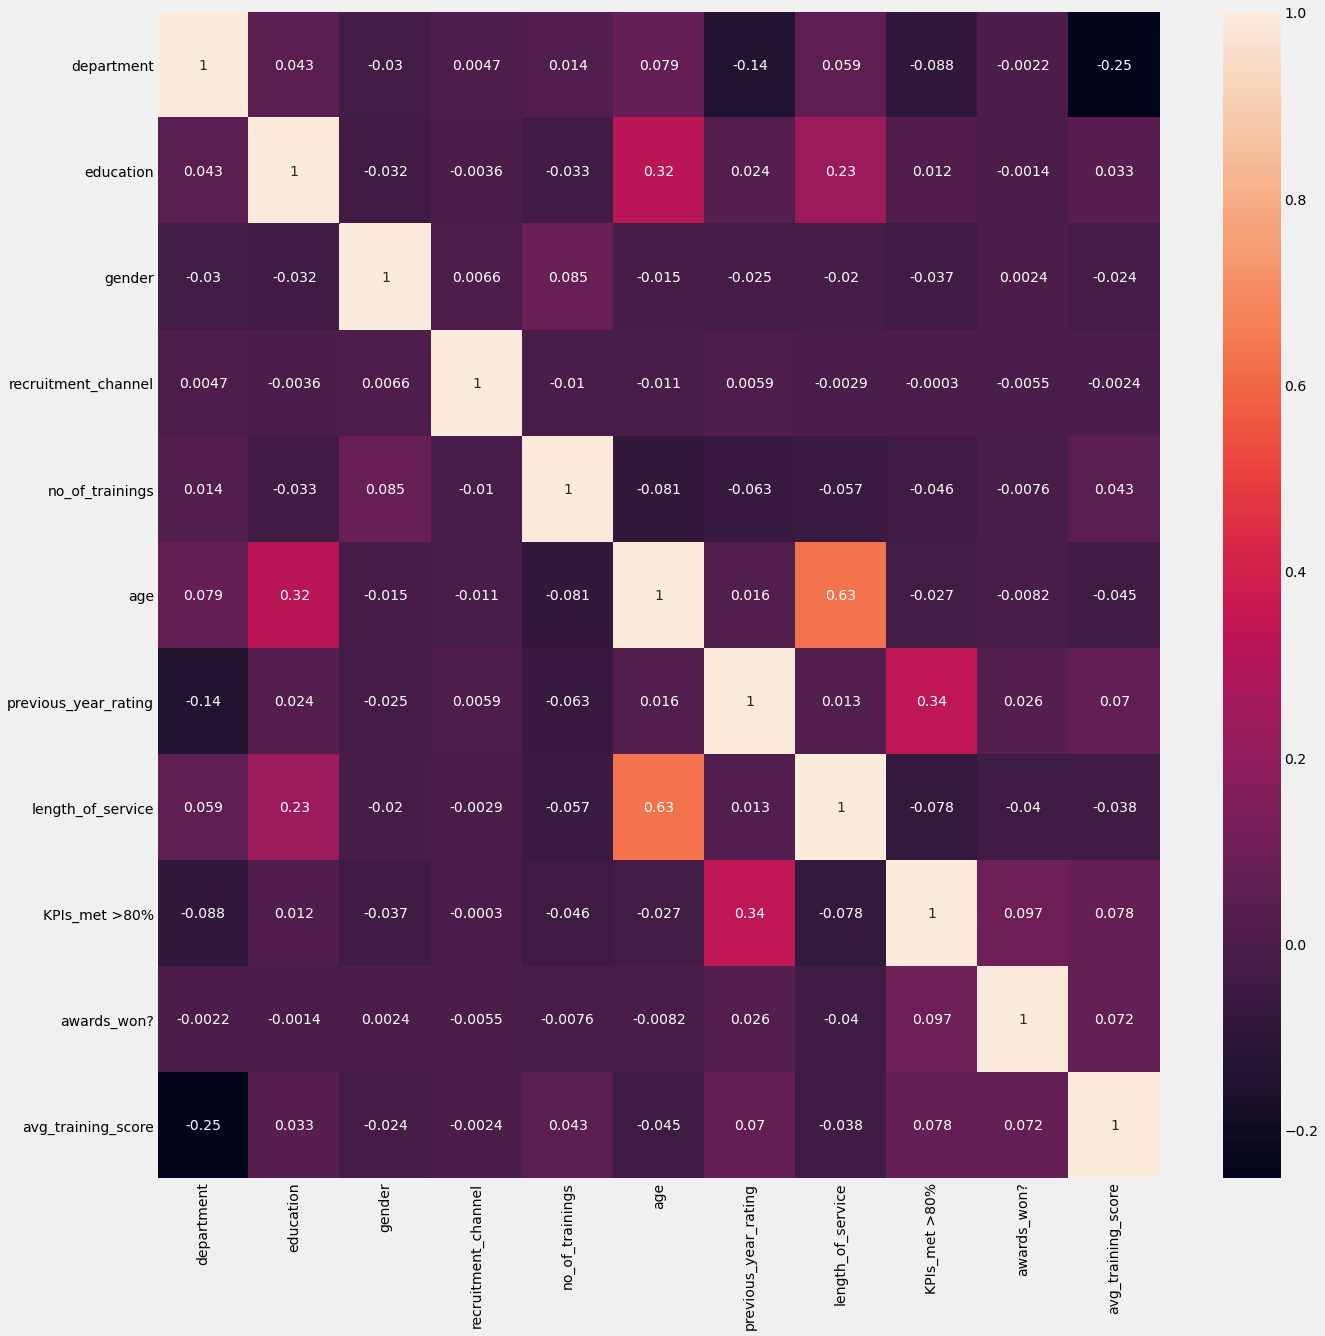

In [69]:
corr= train.iloc[:,1:].corr()
top_features = corr.index

# Plotting the Correlation Plots.
plt.figure(figsize= (20,20))
sns.heatmap(train[top_features].corr(), annot= True)

### 3.3 Information Gain

In [70]:
## Capture the Dependent Variable
y = train[['is_promoted']]

## Capture the Independent Variables
X = train.drop(['is_promoted'], axis= 1)

In [71]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X,y)

In [72]:
mutual_data = pd.Series(mutual_info, index= X.columns)
mutual_data.sort_values(ascending= False)

avg_training_score      0.029177
KPIs_met >80%           0.026712
awards_won?             0.008135
previous_year_rating    0.008090
recruitment_channel     0.007451
department              0.005881
no_of_trainings         0.003111
age                     0.001560
length_of_service       0.001549
gender                  0.000567
education               0.000000
dtype: float64

### Feature Selection - Conclusion

In [73]:
train.drop(columns= ['education'], inplace= True)
train.head()

,is_promoted,department,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,0,0.808933,-1.536223,1.154111,-0.415276,-0.284763,1.385021,0.500460,1.356878,-0.154018,-1.075931
1,0,-0.388183,0.650947,-0.885239,-0.415276,-0.284763,1.385021,-0.437395,-0.736986,-0.154018,-0.253282
2,0,0.808933,0.650947,1.154111,-0.415276,-0.284763,-0.259125,0.265996,-0.736986,-0.154018,-1.001145
3,0,0.808933,0.650947,-0.885239,1.226063,0.718471,-1.903271,0.969387,-0.736986,-0.154018,-1.001145
4,0,1.207972,0.650947,-0.885239,-0.415276,1.721705,-0.259125,-0.906322,-0.736986,-0.154018,0.718939


In [74]:
# convert submission dataframe to csv.
train.to_csv('Final_train.csv', index= False)
print('Final Train csv is ready')

Final Train csv is ready
